<a href="https://colab.research.google.com/github/nytrp/sistemas-inteligentes-para-electronica/blob/main/RNN_expo_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**🌐 Redes Neuronales Recurrentes (RNN)**
## 👥Grupo:

### Alejandro Martinez, Yurliana Niebles, Isaac Montes, Daniel Santiago





## 1) 🧠 ¿Qué es una RNN?

Una Red Neuronal Recurrente (RNN) es una arquitectura de Deep Learning cuya estructura es muy similar a la de una red neuronal convencional, pero diseñada para procesar secuencias; es decir, datos que cambian con el tiempo (videos, conversaciones, texto, series temporales).

El concepto central que da nombre a estas redes es la recurrencia. A diferencia de redes feedforward o convolucionales que consideran solo la entrada actual para generar una salida, las redes recurrentes tienen memoria: guardan información pasada mediante un estado oculto (activación). Esa activación permite que la salida en un instante dependa de entradas previas, por eso las RNN son ideales para secuencias.



## 2) ⚙️¿Cómo funciona? Arquitectura y flujo de datos

### RNN
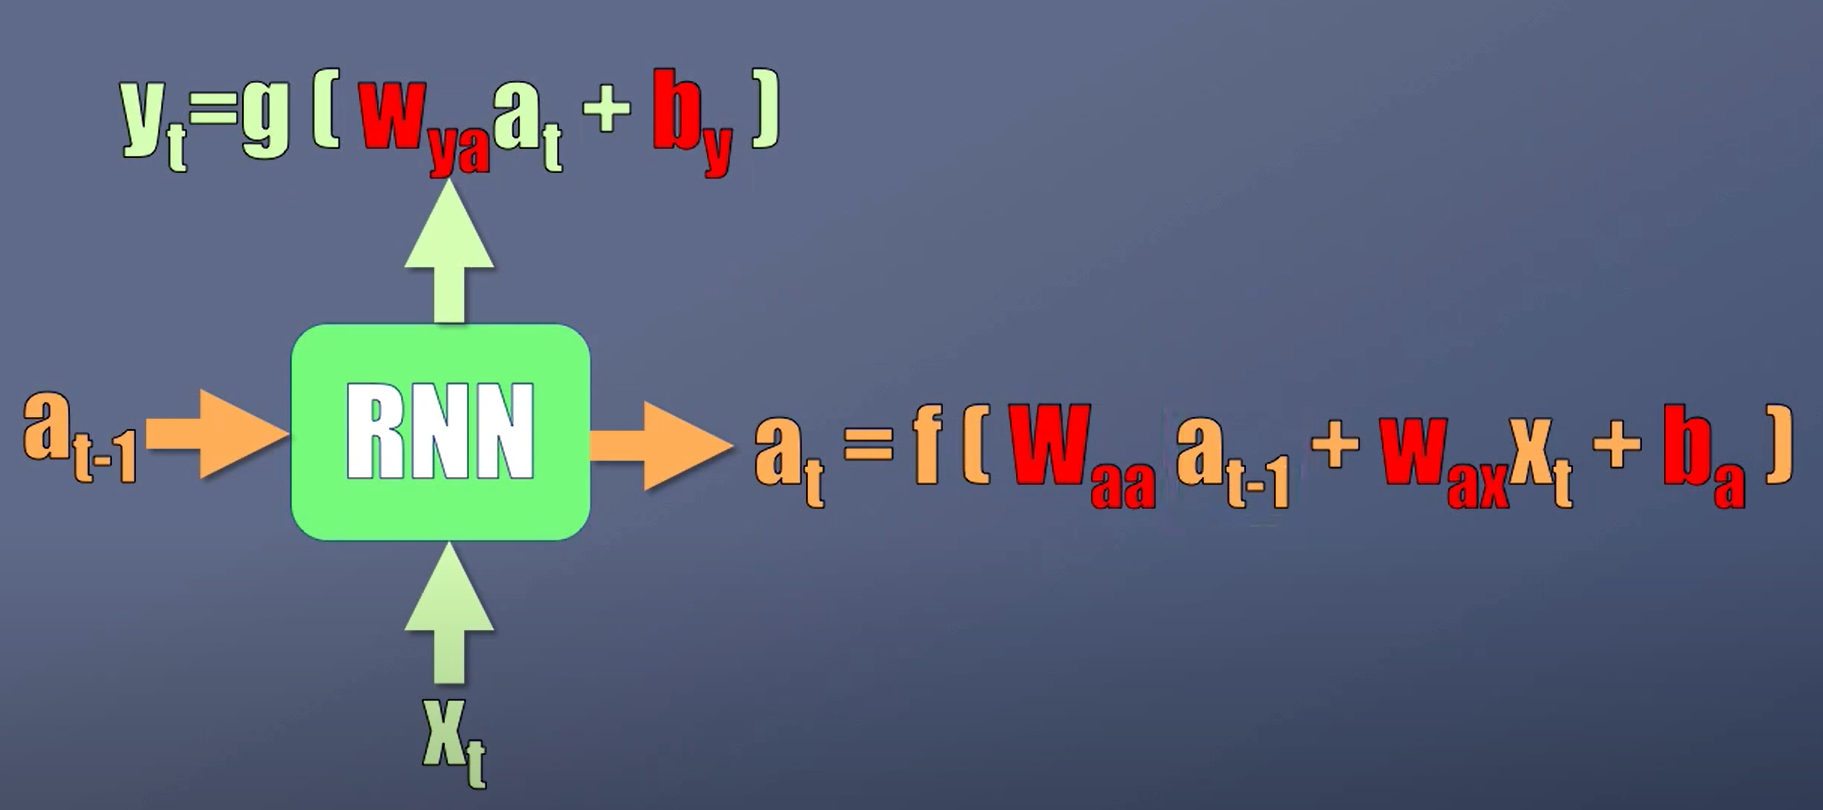
En cada paso temporal t la RNN calcula:

$$
a_t = \phi\big(W_{aa} a_{t-1} + W_{xa} x_t + b_a\big)
$$
$$
y_t = g\big(W_{ay} a_t + b_y\big)
$$

Donde:
- $x_t$: entrada en el tiempo t.
- $a_t$: activación / estado oculto en t (memoria).
- $a_{t-1}$: activación en t-1.
- $y_t$: salida (predicción) en t.
- $W_{xa}, W_{aa}, W_{ay}$ matrices de pesos compartidos; $b_a, b_y$ sesgos.
- $\phi$ es una función no lineal (tanh o ReLU), $g$ depende de la tarea (lineal para regresión).

### Flujo de datos
1. Recibe la entrada actual $x_t$ y la activación previa $a_{t-1}$.
2. Calcula la nueva activación $a_t$ combinando $x_t$ y $a_{t-1}$ con pesos compartidos.
3. Opcionalmente produce una salida $y_t$ a partir de $a_t$ (o usa $a_T$ final para clasificar la secuencia completa).



## 3) 🔁 LSTM (Long Short-Term Memory) — Fórmulas y explicación

LSTM añade una celda de memoria $c_t$ y compuertas que controlan flujo de información.

Ecuaciones estándar:

$$
f_t = \sigma(W_f [x_t, a_{t-1}] + b_f) \quad\text{(puerta de olvido)}
$$

$$
i_t = \sigma(W_i [x_t, a_{t-1}] + b_i) \quad\text{(puerta de entrada)}
$$

$$
\tilde{c}_t = \tanh(W_c [x_t, a_{t-1}] + b_c) \quad\text{(candidato a celda)}
$$

$$
c_t = f_t \odot c_{t-1} + i_t \odot \tilde{c}_t \quad\text{(actualización de la celda)}
$$

$$
o_t = \sigma(W_o [x_t, a_{t-1}] + b_o) \quad\text{(puerta de salida)}
$$

$$
a_t = o_t \odot \tanh(c_t) \quad\text{(estado oculto)}
$$

Explicación breve:
- $f_t$ decide qué olvidar de $c_{t-1}$.
- $i_t$ regula cuánto del candidato $\tilde{c}_t$ entra.
- $o_t$ controla qué parte de $c_t$ se expone en la salida.



## 4)🧪 GRU — versión compacta

GRU simplifica LSTM combinando puertas:

$$
z_t = \sigma(W_z [x_t, a_{t-1}]) \quad\text{(update gate)}
$$

$$
r_t = \sigma(W_r [x_t, a_{t-1}]) \quad\text{(reset gate)}
$$

$$
\tilde{a}_t = \tanh(W [x_t, r_t \odot a_{t-1}])
$$

$$
a_t = (1 - z_t) \odot a_{t-1} + z_t \odot \tilde{a}_t
$$

Menos parámetros que LSTM; rendimiento similar en muchas tareas.

## 5) 🎯¿Para qué sirve?

Las RNN son adecuadas siempre que los datos formen una secuencia. Aplicaciones típicas:

- Procesamiento de lenguaje natural: análisis de sentimiento, generación de texto, traducción (antes de transformers).
- Reconocimiento y síntesis de voz.
- Series temporales: forecasting (consumo, demanda, sensórica).
- Etiquetado secuencial (NER, POS tagging).
- Generación de secuencias (música, nombres, secuencias biológicas).
- Análisis y generación de video (secuencia de frames).




## 6) 📊 Ventajas y desventajas

✅**Ventajas**
- Memoria temporal explícita (estado oculto).
- Adaptadas a secuencias de longitud variable.
- LSTM/GRU manejan dependencias largas mejor que RNN vanilla.

❌**Desventajas**
- BPTT costoso y con problemas numéricos (gradientes).
- Menos paralelizables que Transformers → entrenamiento más lento.
- Para muchas tareas NLP modernas, Transformers superan a RNNs.
- Requieren más datos/ajuste que modelos simples en datasets pequeños.

Celda 1 — Importar librerías

In [15]:
# Celda 1 — Librerías y configuración básica
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from math import sqrt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

Celda 2 — Cargar dataset

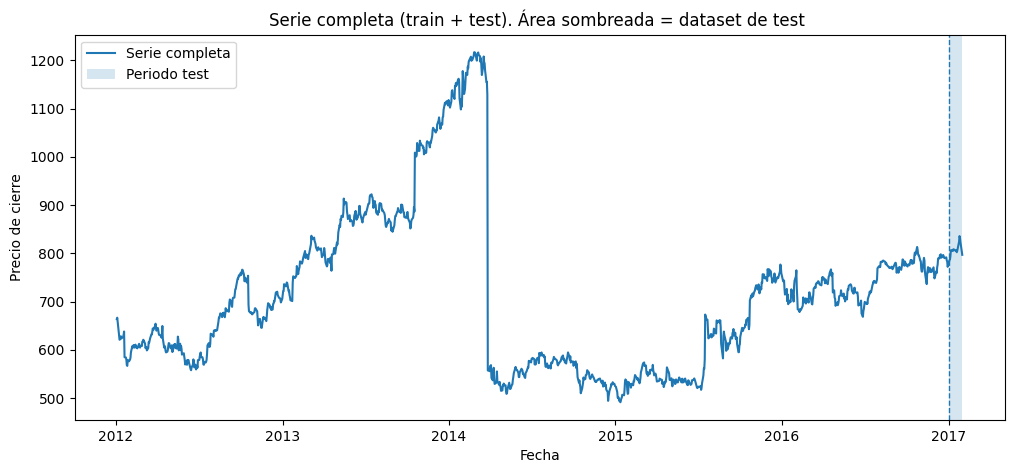

In [17]:
# Celda 2 — Leer datasets de entrenamiento y prueba de Kaggle (gráfica corregida)

# Cargar datos
train_df = pd.read_csv("Google_Stock_Price_Train.csv")
test_df  = pd.read_csv("Google_Stock_Price_Test.csv")

# Convertir Date a datetime
train_df["Date"] = pd.to_datetime(train_df["Date"])
test_df["Date"]  = pd.to_datetime(test_df["Date"])

# Convertir Close a numérico (quitando comas si es necesario)
train_df["Close"] = pd.to_numeric(train_df["Close"].astype(str).str.replace(",", ""), errors="coerce")
test_df["Close"]  = pd.to_numeric(test_df["Close"].astype(str).str.replace(",", ""), errors="coerce")

# Establecer fecha como índice
train_df.set_index("Date", inplace=True)
test_df.set_index("Date", inplace=True)

# Usar solo columna Close
train_df = train_df[["Close"]]
test_df  = test_df[["Close"]]

# Construir serie continua y graficar de forma clara:
full_df = pd.concat([train_df, test_df], axis=0)

plt.figure(figsize=(12,5))
plt.plot(full_df.index, full_df["Close"], label="Serie completa")
# sombrear periodo de test para que quede claro que es la porción reservada para evaluación
start_test = test_df.index[0]
end_test   = test_df.index[-1]
plt.axvspan(start_test, end_test, alpha=0.18, label="Periodo test ")
plt.axvline(start_test, linestyle="--", linewidth=1)  # marca visual del inicio del test

plt.title("Serie completa (train + test). Área sombreada = dataset de test ")
plt.xlabel("Fecha")
plt.ylabel("Precio de cierre")
plt.legend()
plt.show()



Celda 3 — Preprocesamiento y ventanas

In [18]:
# Celda 3 — Preprocesamiento con Train + Test

# Concatenar train y test para hacer un escalado uniforme
full_data = pd.concat((train_df, test_df), axis=0)

# Escalar valores de la columna Close
scaler = MinMaxScaler(feature_range=(0,1))
scaled_full = scaler.fit_transform(full_data["Close"].values.reshape(-1,1))

# Dividir de nuevo: entrenamiento y prueba
train_scaled = scaled_full[:len(train_df)]
test_scaled  = scaled_full[len(train_df)-60:]  # ojo: incluimos últimos 60 del train para contexto

# Crear ventanas (función auxiliar)
def create_windows(data, window=60):
    X, y = [], []
    for i in range(window, len(data)):
        X.append(data[i-window:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

WINDOW = 60

# Conjuntos
X_train, y_train = create_windows(train_scaled, WINDOW)
X_test,  y_test  = create_windows(test_scaled, WINDOW)

# Redimensionar para LSTM [samples, timesteps, features]
X_train_l = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_l  = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

print("X_train_l shape:", X_train_l.shape)
print("X_test_l shape:", X_test_l.shape)




X_train_l shape: (1198, 60, 1)
X_test_l shape: (20, 60, 1)


Celda 4 — Modelo LSTM (RNN mejorada)

In [19]:
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(WINDOW,1)),
    Dropout(0.1),
    LSTM(64, return_sequences=False),
    Dropout(0.1),
    Dense(1, activation="linear")
])

model.compile(optimizer="adam", loss="mse")
history = model.fit(X_train_l, y_train, epochs=100, batch_size=32,
                    validation_data=(X_test_l, y_test), verbose=1)



Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 155ms/step - loss: 0.0352 - val_loss: 3.1258e-04
Epoch 2/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 103ms/step - loss: 0.0063 - val_loss: 3.3135e-04
Epoch 3/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - loss: 0.0034 - val_loss: 0.0014
Epoch 4/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - loss: 0.0037 - val_loss: 6.3644e-04
Epoch 5/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 104ms/step - loss: 0.0028 - val_loss: 4.6050e-04
Epoch 6/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - loss: 0.0018 - val_loss: 8.6042e-04
Epoch 7/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - loss: 0.0029 - val_loss: 5.4490e-04
Epoch 8/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - loss: 0.0018 - val_loss: 0.0014
Epoch 9/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 180ms/step - loss: 0.0024 - val_loss: 0.0012
Epoch 10/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 106ms/step - loss: 0.0018 - val_loss: 7.3793e-04
Epoch 11/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 106ms/step - loss: 0.0024 - val_loss: 4.0365e-04
Epoch 12/100
38/38 ━━

Celda 5 - Entrenamiento en vivo

In [21]:
# Entrenamiento en vivo (últimas 5 épocas)
history_extra = model.fit(
    X_train_l, y_train,
    epochs=5,
    batch_size=32,
    validation_data=(X_test_l, y_test),
    verbose=1
)


Epoch 1/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - loss: 7.5479e-04 - val_loss: 2.2417e-04
Epoch 2/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - loss: 0.0011 - val_loss: 1.5329e-04
Epoch 3/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 104ms/step - loss: 0.0016 - val_loss: 2.3150e-04
Epoch 4/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - loss: 5.1889e-04 - val_loss: 4.1308e-04
Epoch 5/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - loss: 0.0015 - val_loss: 1.4353e-04


Celda 6 — Evaluación del LSTM

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step
LSTM RMSE: 8.693222945837714
LSTM R2: 0.544145122569889


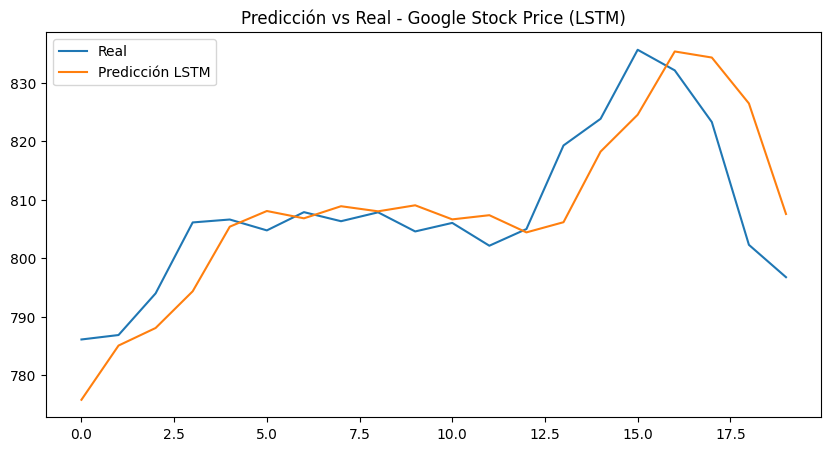

In [22]:
# Celda 5 — Evaluar el modelo LSTM

# Predicción sobre el set de prueba
y_pred = model.predict(X_test_l)

# Desescalar (aseguramos formato 2D)
y_pred_inv = scaler.inverse_transform(y_pred)                 # ya está en 2D
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))  # corregido

# Calcular métricas
rmse = sqrt(mean_squared_error(y_test_inv, y_pred_inv)) #raíz cuadrada del error cuadrático medio
r2   = r2_score(y_test_inv, y_pred_inv) # coeficiente de determinación

print("LSTM RMSE:", rmse)
print("LSTM R2:", r2)

# Gráfico comparando valores reales vs predicciones
plt.figure(figsize=(10,5))
plt.plot(y_test_inv, label="Real")
plt.plot(y_pred_inv, label="Predicción LSTM")
plt.title("Predicción vs Real - Google Stock Price (LSTM)")
plt.legend()
plt.show()


Celda 7 — Comparación con modelos clásicos

Metricas Regresión Lineal
LR RMSE: 8.211199250583263
LR R2: 0.5932962732124669
Metricas Random Forest
RF RMSE: 10.017666919198376
RF R2: 0.3946617097567515


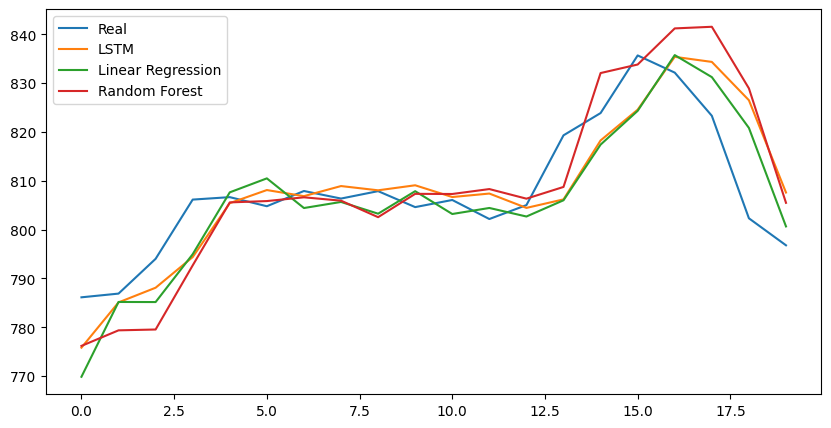

In [23]:
# Aplanar ventanas para modelos clásicos
X_train_c = X_train.reshape(X_train.shape[0], -1)
X_test_c = X_test.reshape(X_test.shape[0], -1)

# Regresión Lineal
lr = LinearRegression()
lr.fit(X_train_c, y_train)
y_pred_lr = scaler.inverse_transform(lr.predict(X_test_c).reshape(-1,1))
print("Metricas Regresión Lineal")
print("LR RMSE:", sqrt(mean_squared_error(y_test_inv, y_pred_lr)))
print("LR R2:", r2_score(y_test_inv, y_pred_lr))

# Random Forest
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train_c, y_train.ravel())
y_pred_rf = scaler.inverse_transform(rf.predict(X_test_c).reshape(-1,1))
print("Metricas Random Forest")
print("RF RMSE:", sqrt(mean_squared_error(y_test_inv, y_pred_rf)))
print("RF R2:", r2_score(y_test_inv, y_pred_rf))

# Comparativa en gráfico
plt.figure(figsize=(10,5))
plt.plot(y_test_inv, label="Real")
plt.plot(y_pred_inv, label="LSTM")
plt.plot(y_pred_lr, label="Linear Regression")
plt.plot(y_pred_rf, label="Random Forest")
plt.legend()
plt.show()
